In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import sys, time, os, random
from os.path import join as oj
from tqdm import tqdm
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable


import visualize as viz
import tiling
import agglomerate
from cd import cd

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import imagenet.imagenet as dset

from agglomerate import get_scores
import torchvision.datasets as datasets
from torchvision import models

# get model
# model = models.alexnet(pretrained=True).cuda().eval()
model = models.vgg16(pretrained=True).cuda().eval()
model_type='vgg' # alexnet, vgg

# try running cd

In [2]:
# make blob
im_torch, _, label_num = dset.get_im_and_label(0) # remember torch is H x W x C
blob = np.zeros((3, 224, 224))
blob[:, 5:10, 15:20] = 1
# print('im_torch.shape', im_torch.shape, 'blob.shape', blob.shape, blob.dtype)

# calculate cd score
rel, irrel, scores = cd(blob, im_torch, model, model_type=model_type)

# compare to pred
pred = model.forward(im_torch).data.cpu().numpy()
out = (rel + irrel).data.cpu().numpy()
# print(out.flatten()[:5], '\n', pred.flatten()[:5], sep='')
print((out.flatten() - pred.flatten())[:5])
print(pred.flatten()[:5])

[0.00012565 0.00017881 0.00012434 0.00010407 0.00023544]
[-1.6781542 -2.9579997 -1.7997382 -1.2119743 -1.8157492]


# look at different scores

In [125]:
def get_diff_scores(im_torch, im_orig, label_num, model, preds):
    scores = []

    # cd
    method = 'cd'
    tiles = tiling.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
    scores_cd = agglomerate.get_scores(model, method=method, ims=tiles, 
                                   im_torch=im_torch, model_type=model_type)
    scores.append(scores_cd)
    for method in ['break_down', 'build_up']:
        tiles_break = tiling.gen_tiles(im_orig, fill=0, method=method, sweep_dim=sweep_dim)
        preds_break = agglomerate.get_scores(model, method=method, ims=tiles_break, 
                                            im_torch=im_torch, pred_ims=dset.pred_ims)
        if method == 'break_down':
            preds_break += preds
        scores.append(np.copy(preds_break))
    
    return scores



# pick an image + get scores
im_nums = [34, 20, 36, 32] # 20 is green mamba, 32 is crane, 34 is screen, 36 trash can
sweep_dim = 14
fig = plt.figure(figsize=(8, 8), facecolor='white')

for x, im_num in enumerate(im_nums):

    im_torch, im_orig, label_num = dset.get_im_and_label(im_num) # remember torch is H x W x C
    print('lab', dset.lab_dict[label_num])
    # viz.visualize_ims_tiled(tiling.gen_tiles(im_orig, fill=np.nan))
    preds = dset.pred_ims(model, im_orig).flatten()
    ind = np.argpartition(preds, -8)[-8:] # top-scoring indexes
    ind = ind[np.argsort(preds[ind])][::-1] # sort the indexes
    scores = get_diff_scores(im_torch, im_orig, label_num, model, preds)

    # plot raw image
    num_rows = len(im_nums)
    num_cols = 4
    plt.subplot(num_rows, num_cols, 1 + x * num_cols)
    plt.imshow(im_orig)
#     plt.axis('off')
    plt.gca().xaxis.set_visible(False)
    plt.yticks([])
    if x == 0:
        plt.title('Image', fontsize=16)

    if x == 0:
        plt.ylabel('CRT screen', fontsize=15)
    elif x == 1:
        plt.ylabel('Green mamba', fontsize=15)
    elif x == 2:
        plt.ylabel('Trash can', fontsize=15)
    elif x == 3:
        plt.ylabel('Crane', fontsize=15)


    # plot scores
    vmax = max([np.max(scores[i]) for i in range(len(scores))])
    vmin = min([np.min(scores[i]) for i in range(len(scores))])
    vabs = max(abs(vmax), abs(vmin))
    for i, tit in enumerate(['CD', 'Occlusion', 'Build up']):
        plt.subplot(num_rows, num_cols, 2 + i + x * num_cols)
        if i == 0:
            plt.ylabel('pred: ' + dset.lab_dict[ind[0]][:16] + '...', fontsize=15)     
        if x == 0:
            plt.title(tit, fontsize=16)
        p = viz.visualize_preds(scores[i], num=label_num, cbar=False) #axis_off=False,  vabs=vabs)
        plt.xticks([])
        plt.yticks([])
#     divider = make_axes_locatable(plt.gca())
#     cax = divider.append_axes("right", size="2%", pad=0.05)
#     plt.colorbar(p, cax=cax)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

SyntaxError: invalid syntax (<ipython-input-125-2ee4fed63f4b>, line 77)

In [68]:
dset.lab_dict[ind[0]][:16]

'diaper, nappy, n'

# look at top classes

In [126]:
im_torch, im_orig, label = dset.get_im_and_label(im_num) # remember torch is CWH
plt.imshow(im_orig)
plt.title('label: ' + dset.lab_dict[label])
plt.show()

viz.visualize_top_classes(model, dset, im_orig, scores_cd)
plt.show()

SyntaxError: invalid syntax (<ipython-input-126-048367cd5de8>, line 7)

# run agglomeration

In [ ]:
# hyperparams
num_iters = 5 # 8 is good, fig uses 4
percentile_includes = [95] # 0 - 100, 99 is good, 75 picks a lot, fig uses 95
methods = ['cd'] # build_up, break_down, cd
sweep_dims = [14] # 14 is good, 7 is too small
im_nums = range(9, 10) # 9 is hockey
layer = 'softmax' # softmax or logit
use_abs_list = [False]
batch = False

for method in methods:
    for sweep_dim in sweep_dims:
        for percentile_include in percentile_includes:
            for im_num in tqdm(im_nums):
                for use_abs in use_abs_list:
                    im_torch, im_orig, lab_num_correct = dset.get_im_and_label(im_num)
                    lab_pred = np.argmax(dset.pred_ims(model, np.copy(im_orig)))

                    lists = agglomerate.agglomerate(model, dset.pred_ims, percentile_include, 
                                                    method, sweep_dim, layer, im_orig, 
                                                    lab_pred, use_abs, num_iters=num_iters, 
                                                    im_torch=im_torch, batch=batch, model_type=model_type)        


                    # visualize
                    plt.figure(figsize=(12, 11), facecolor='white')

                    rows = 7       
                    num_ims = len(lists['scores_list'])

                    # original plots
                    ind, labs = viz.visualize_original_preds(im_orig, lab_num_correct, 
                                                             lists['comp_scores_raw_list'], lists['scores_orig_raw'],
                                                             subplot_rows=rows, dset=dset)

                    # comp plots
                    viz.visualize_ims_list(lists['scores_list'], 
                                           cmap_new='redwhiteblue',
                                           title=dset.lab_dict[lab_pred] + ' scores',
                                           subplot_row=2, subplot_rows=rows, colorbar=True)
                    viz.visualize_ims_list(lists['comps_list'],
                                          title='Chosen blobs',
                                          subplot_row=3, subplot_rows=rows, colorbar=False, im_orig=im_orig, plot_overlay=True)

                    # dict plots
                    viz.visualize_dict_list_top(lists['comp_scores_raw_list'], method,
                                           subplot_row=4, subplot_rows=rows, ind=ind, labs=labs, use_orig_top=True)
                    viz.visualize_dict_list_top(lists['comp_scores_raw_list'], method,
                                    subplot_row=6, subplot_rows=rows, ind=ind, 
                                    dset=dset, use_orig_top=False)

                    # save
                    out_dir = oj('vision_results/imagenet', model_type, method)
                    if not os.path.exists(out_dir):
                        os.makedirs(out_dir)
                    plt.savefig(oj(out_dir, str(im_num) + '_' + method + 
                                   '_perc=' + str(percentile_include) + '.png'))

# mturk viz

In [117]:
# visualize
plt.figure(figsize=(12, 4), facecolor='white')
mturk=True
rows = 2     

# original plots
ind, labs = viz.visualize_original_preds(im_orig, lab_num_correct, 
                                         lists['comp_scores_raw_list'], lists['scores_orig_raw'],
                                         subplot_rows=rows, dset=dset, mturk=mturk)
# comp plots
viz.visualize_ims_list(np.copy(lists['comps_list']), title='', subplot_row=1, subplot_rows=rows, 
                       colorbar=False, im_orig=im_orig, plot_overlay=True, 
                       mturk=mturk, num_ims=lists['num_before_final'], comp_scores_raw=lists['comp_scores_raw_list'], lab_num_correct=lab_pred) # mturk stuff

# save
out_dir = oj('vision_results/imagenet', model_type, method)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
plt.savefig(oj(out_dir, str(im_num) + '_' + method + 
               '_perc=' + str(percentile_include) + '_mturk.png'))

SyntaxError: invalid syntax (<ipython-input-117-d9e4e18296d5>, line 20)

# agglom fig 2-part

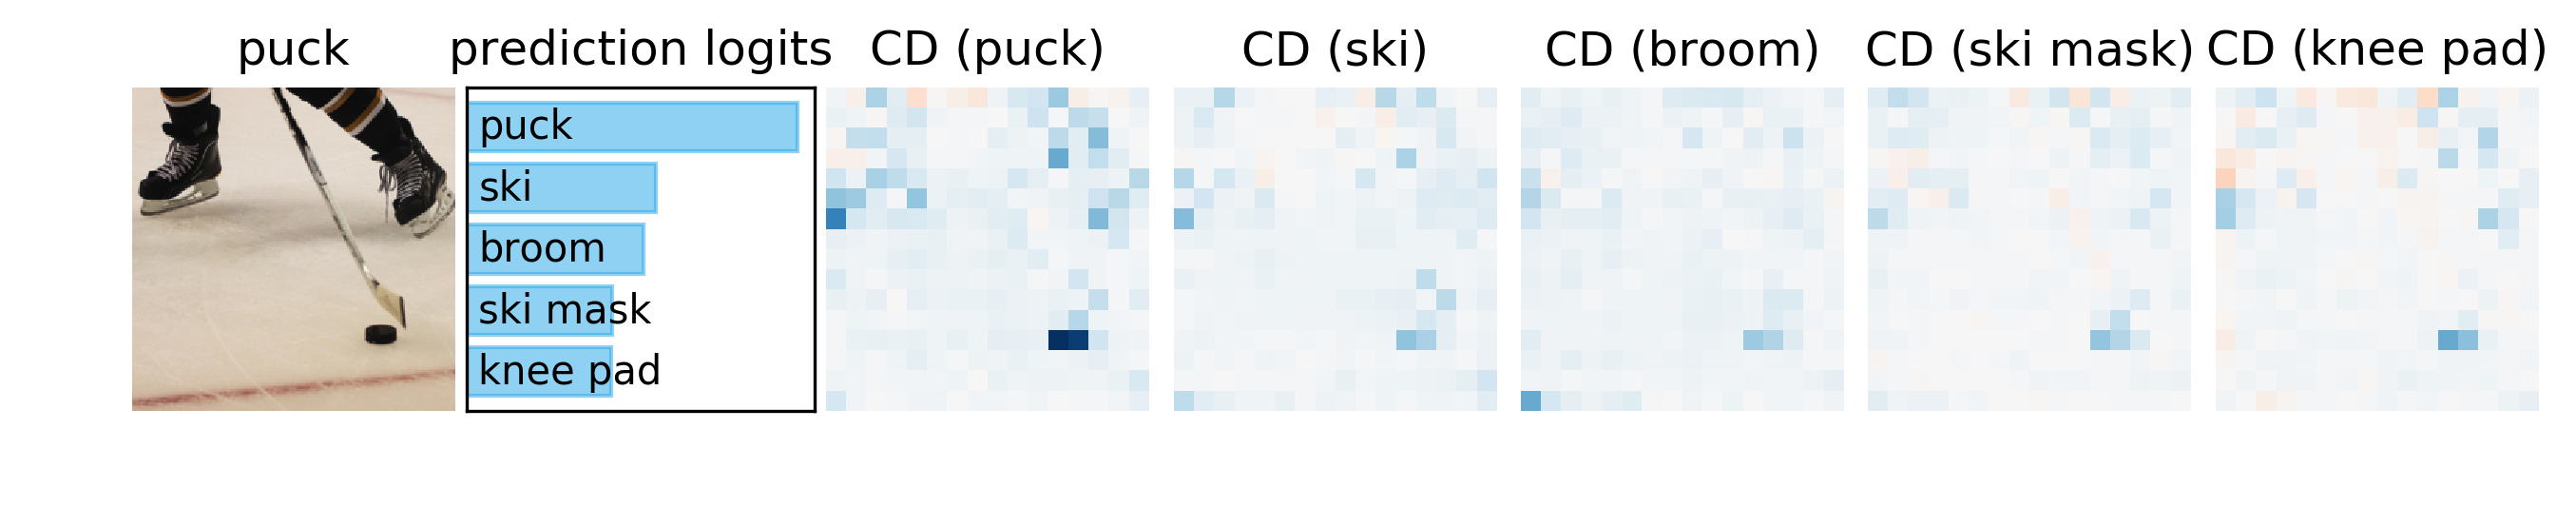

"\nplt.figure(figsize=(12, 4), facecolor='white', dpi=300)\nrows = 2\nnum_ims = len(lists['scores_list'])\nlabs[0] = 'puck'\nviz.visualize_ims_list(lists['comps_list'][1:],\n                      title='Chosen blobs',\n                      subplot_row=0, subplot_rows=rows, colorbar=False, \n                       im_orig=im_orig, plot_overlay=True, num_ims=7, skip_first=True)\n# dict plots\nviz.visualize_dict_list_top(lists['comp_scores_raw_list'], method,\n                       subplot_row=1, subplot_rows=rows, ind=ind, labs=labs, \n                       use_orig_top=True, num_ims=7, skip_first=True, vmin=-1, vmax=10)\nplt.show()\n"

In [14]:
percentile_include = 95
method = 'cd'
sweep_dim = 14
layer = 'softmax'
use_abs = False
num_iters = 5
batch = False

im_num = 9
im_torch, im_orig, lab_num_correct = dset.get_im_and_label(im_num)
lab_pred = np.argmax(dset.pred_ims(model, np.copy(im_orig)))

'''
lists = agglomerate.agglomerate(model, dset.pred_ims, percentile_include, 
                                method, sweep_dim, layer, im_orig, 
                                lab_pred, use_abs, num_iters=num_iters, 
                                im_torch=im_torch, batch=batch, model_type=model_type)        
'''
    
# top fig
plt.figure(figsize=(11, 1.5), facecolor='white', dpi=300)
rows = 1
num_ims = len(lists['scores_list'])

# original plots
tits = ['puck', 'prediction logits', 'CD (puck)', 'CD (ski)', 'CD (broom)', 'CD (ski mask)', 'CD (knee pad)']
ind, labs = viz.visualize_original_preds(im_orig, lab_num_correct, 
                                         lists['comp_scores_raw_list'], lists['scores_orig_raw'],
                                         subplot_rows=rows, dset=dset, tits=tits)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()


# bot fig
'''
plt.figure(figsize=(12, 4), facecolor='white', dpi=300)
rows = 2
num_ims = len(lists['scores_list'])
labs[0] = 'puck'
viz.visualize_ims_list(lists['comps_list'][1:],
                      title='Chosen blobs',
                      subplot_row=0, subplot_rows=rows, colorbar=False, 
                       im_orig=im_orig, plot_overlay=True, num_ims=7, skip_first=True)
# dict plots
viz.visualize_dict_list_top(lists['comp_scores_raw_list'], method,
                       subplot_row=1, subplot_rows=rows, ind=ind, labs=labs, 
                       use_orig_top=True, num_ims=7, skip_first=True, vmin=-1, vmax=10)
plt.show()
'''

# generate final examples...

In [5]:
good_exs = [4195, 22182, 35727, 1939, 4020, 6910]
bad_exs = [7224, 28123, 48736]
all_exs = set(good_exs + bad_exs)
found_exs = 0

data = {}
_, data_loader = dset.load_data()
for i, im in enumerate(data_loader):
    if i in all_exs:
        print(i)
        im_orig = np.copy(im[0].numpy()).squeeze() # original numpy image for viewing
        im_norm = dset.normalize(im[0][0]).unsqueeze(0)
        im_torch = Variable(im_norm.cuda()) # torch image for passing through net
        label = im[1].numpy()[0]
        
        found_exs += 1
        data[i] = (im_torch, im_orig.transpose((1, 2, 0)), label)
        if found_exs == len(all_exs):
            break
            

1939
4020
4195
6910
7224
22182
28123
35727
48736


In [122]:
percentile_include = 96
method = 'cd'
sweep_dim = 14
layer = 'softmax'
use_abs = False
num_iters = 8
batch = False


good_exs = [4195, 22182, 35727, 1939, 4020, 6910]
bad_exs = [7224, 28123, 48736]
for im_num in good_exs + bad_exs:
    print(im_num)
    im_torch, im_orig, lab_num_correct = data[im_num] #dset.get_im_and_label(im_num)
    lab_pred = np.argmax(dset.pred_ims(model, np.copy(im_orig)))

    lists = agglomerate.agglomerate(model, dset.pred_ims, percentile_include, 
                                    method, sweep_dim, layer, im_orig, 
                                    lab_pred, use_abs, num_iters=num_iters, 
                                    im_torch=im_torch, batch=batch, model_type=model_type)        


    # visualize
    plt.figure(figsize=(12, 2), facecolor='white', dpi=300)
    rows = 1
    num_ims = len(lists['scores_list'])

    # original plots
    tits = None #['puck', 'prediction logits', 'CD (puck)', 'CD (ski)', 'CD (broom)', 'CD (ski mask)', 'CD (knee pad)']
    ind, labs = viz.visualize_original_preds(im_orig, lab_num_correct, 
                                             lists['comp_scores_raw_list'], lists['scores_orig_raw'],
                                             subplot_rows=rows, dset=dset, tits=tits)
    # save as something....
    plt.savefig(oj('out', str(im_num) + '_' + method + 
                   '_perc=' + str(percentile_include) + '_1.png'), bbox_inches='tight')
    #plt.show()


    plt.figure(figsize=(12, 4), facecolor='white', dpi=300)
    rows = 2
    num_ims = len(lists['scores_list'])
    #labs[0] = 'puck'
    viz.visualize_ims_list(lists['comps_list'][1:],
                          title='Chosen blobs',
                          subplot_row=0, subplot_rows=rows, colorbar=False, 
                           im_orig=im_orig, plot_overlay=True, num_ims=7, skip_first=True)

    # dict plots

    viz.visualize_dict_list_top(lists['comp_scores_raw_list'], method,
                           subplot_row=1, subplot_rows=rows, ind=ind, labs=labs, 
                           use_orig_top=True, num_ims=7, skip_first=True)#, vmin=-1, vmax=10)

    # save as something...
    plt.savefig(oj('out', str(im_num) + '_' + method + 
                   '_perc=' + str(percentile_include) + '_2.png'), bbox_inches='tight')
    plt.show()
    

4195


NameError: name 'data' is not defined

In [19]:
dict_list = lists['comp_scores_raw_list']
max([np.max(d[key]) for d in dict_list[1:8] for key in d]) + 1

5.51125955581665

# cd propagation fig

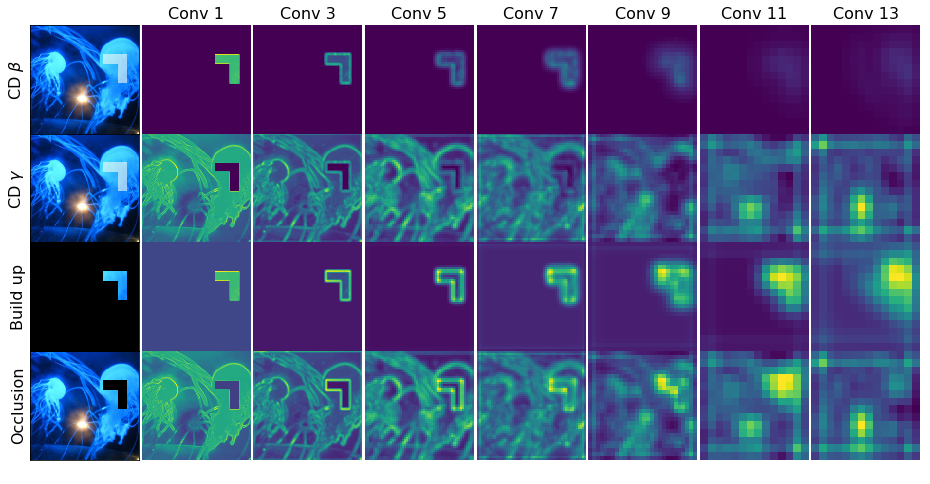

In [124]:
def vgg(im_torch, model):
    # set up model
    model.eval()
    mods = list(model.modules())[2:]
    scores = []
    x = im_torch.clone()
    for i in range(30):
        x = mods[i](x)
        if i in [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]: # all the conv 2d layers
            scores.append(x.clone())
    return scores


# calculate cd score
f = 16
im_num = 10
im_torch, im_orig, label_num = dset.get_im_and_label(im_num) # remember torch is H x W x C

# set up blob
blob = np.zeros((3, 224, 224))
blob[:, 60:80, 150:200] = 1
blob[:, 60:120, 180:200] = 1

rel1, irrel1, scores = cd(blob, im_torch, model, model_type=model_type)
scores = [scores[i] for i in np.arange(0, len(scores), 2)] # pick every other

# calculate build_up score
im_torch2, im_orig, label_num = dset.get_im_and_label(im_num) # remember torch is H x W x C
im_torch2[0, :, :60, :] = 0
im_torch2[0, :, :, :150] = 0
im_torch2[0, :, 80:120, :180] = 0
im_torch2[0, :, :, 200:] = 0
im_torch2[0, :, 120:, :] = 0
scores2 = vgg(im_torch2, model)
scores2 = [scores2[i] for i in np.arange(0, len(scores2), 2)] # pick every other

# calculate break_down score
im_torch, im_orig, label_num = dset.get_im_and_label(im_num) # remember torch is H x W x C

im_torch[0, :, 60:80, 150:200] = 0
im_torch[0, :, 60:120, 180:200] = 0

scores3 = vgg(im_torch, model)
scores3 = [scores3[i] for i in np.arange(0, len(scores3), 2)] # pick every other


plot_bottom_rows = True

# set up figure
if plot_bottom_rows:
    plt.figure(figsize=(16, 8))
    num_rows = 4
else:
    plt.figure(figsize=(16, 4))
    num_rows = 2   
num_cols = len(scores) + 1

# show original ims
# plt.subplot2grid((num_rows, num_cols), (0, 0), rowspan=num_rows)
# plt.gcf().text(0.18, 0.85, 'Blob', fontsize=14)
# plt.gcf().text(0.16, 0.15, 'Non-blob', fontsize=14)
plt.subplot(num_rows, num_cols, 1)
plt.imshow(im_orig)
blob_show = np.copy(blob[0])
blob_show[blob_show == 0] = np.nan
plt.imshow(blob_show, alpha=0.6, cmap='Greens')
plt.ylabel('CD $\\beta$', fontsize=f)
plt.xticks([])
plt.yticks([])


plt.subplot(num_rows, num_cols, num_cols + 1)
plt.imshow(im_orig, cmap='Greens')
plt.imshow(blob_show, alpha=0.6, cmap='Greens')
plt.ylabel('CD $\\gamma$', fontsize=f)
plt.xticks([])
plt.yticks([])

if plot_bottom_rows:
    plt.subplot(num_rows, num_cols, num_cols * 3 + 1)
    im_blob = np.copy(im_orig)
    blob_idxs = blob.astype(np.int).transpose((1, 2, 0))
    im_blob[blob_idxs] = 0
    im_blob[60:80, 150:200] = 0
    im_blob[60:120, 180:200] = 0
    plt.imshow(im_blob)
    plt.ylabel('Occlusion', fontsize=f)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(num_rows, num_cols, num_cols * 2 + 1)
    im_blob = np.copy(im_orig)
    blob_idxs = blob.astype(np.int).transpose((1, 2, 0))
    # im_blob[blob_idxs] = 0
    # im_blob[60:80, 150:200] = 0
    # im_blob[60:120, 180:200] = 0

    im_blob[:60, :] = 0
    im_blob[:, :150] = 0
    im_blob[80:120, :180] = 0
    im_blob[:, 200:] = 0
    im_blob[120:, :] = 0
    plt.imshow(im_blob)
    plt.ylabel('Build up', fontsize=f)
    plt.xticks([])
    plt.yticks([])

# show propagating images
for i in range(len(scores)):
    rel1, irrel1 = scores[i]
    x = np.squeeze(rel1.data.cpu().numpy())
    x = np.sum(np.abs(x), axis=0)

    y = np.squeeze(irrel1.data.cpu().numpy())
    y = np.sum(np.abs(y), axis=0)

    rel2 = scores2[i]
    z = np.squeeze(rel2.data.cpu().numpy())
    z = np.sum(np.abs(z), axis=0)

    rel3 = scores3[i]
    zz = np.squeeze(rel3.data.cpu().numpy())
    zz = np.sum(np.abs(zz), axis=0)
    
    vmax1, vmin1 = max(np.max(x), np.max(z)), min(np.min(x), np.min(z))
    vmax2, vmin2 = max(np.max(y), np.max(zz)), min(np.min(y), np.min(zz))

    # top row
    plt.subplot(num_rows, num_cols, i + 2)
    plt.imshow(x, interpolation='None', vmin=vmin1, vmax=vmax1)
    plt.axis('off')
    plt.title('Conv ' + str(2*i+1), fontsize=f)
    
    # plot 2
    plt.subplot(num_rows, num_cols, num_cols + i + 2)
    plt.imshow(y, interpolation='None', vmin=vmin2, vmax=vmax2)
    plt.axis('off')
    
    if plot_bottom_rows:
    
        # plot 3
        plt.subplot(num_rows, num_cols, num_cols * 2 + i + 2)
        plt.imshow(z, interpolation='None', cmap='viridis', vmin=vmin1, vmax=vmax1)
        plt.axis('off')    

        # plot 4
        plt.subplot(num_rows, num_cols, num_cols * 3 + i + 2)
        plt.imshow(zz, interpolation='None', cmap='viridis', vmin=vmin2, vmax=vmax2)
        plt.axis('off')
    
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [72]:
im_torch, im_orig, lab_num_correct = dset.get_im_and_label(9)